In [36]:
using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using StatsBase

using CairoMakie
CairoMakie.activate!(type="png")
set_theme!(resolution=(800, 400))
CairoMakie.inline!(true)
using GraphMakie: graphplot
using GeometryBasics: Point


function mylayout(g::AbstractGraph)
    return Point.(zip(x[:, 1], x[:, 2]))
end


mylayout (generic function with 1 method)

In [37]:
rng = Random.default_rng();

k = 20;
x1 = 0.2*randn(rng, (k,2));
x2 = 0.2*randn(rng, (k,2)) .+ [1 0];

x = [x1;x2];

n = size(x,1)
meta_g = MetaGraph(n)
       
bw = .5
for i = 1:n
    for j = (i+1):n
        w = exp(-norm(x[i,:]-x[j,:])^2/bw^2)
        if w > 1e-3
            e = (i,j)
            add_edge!(meta_g, i, j, :angle, 0.0)
            set_prop!(meta_g, Edge(e), :e_weight, w)
        end
    end
end

nb_samples = 10
q = 4
ls = nothing
weighted = true
L = average_sparsifier(rng, meta_g, ls, q, nb_samples; weighted)
A = abs.(L - Diagonal(L))
subgraph = Graph(A)

{40, 211} undirected simple Int64 graph

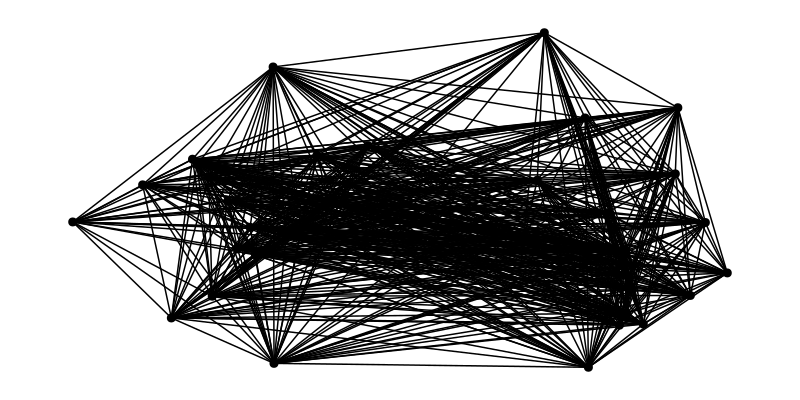

In [38]:
f, ax, p = graphplot(meta_g; layout=mylayout)
hidedecorations!(ax); hidespines!(ax)
ax.aspect = DataAspect()
f

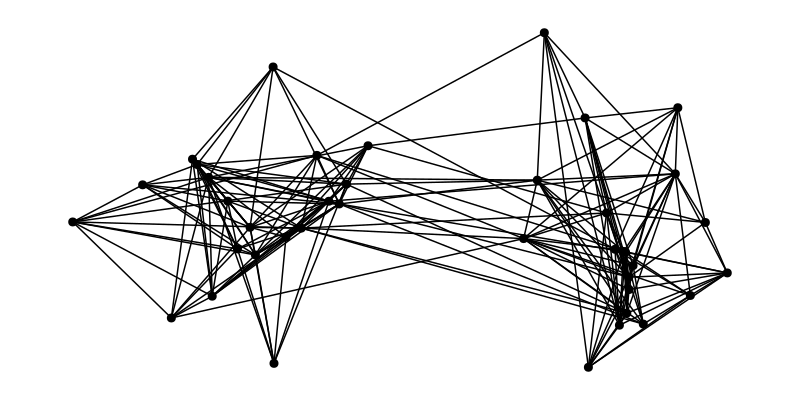

In [39]:
f, ax, p = graphplot(subgraph; layout=mylayout)
hidedecorations!(ax); hidespines!(ax)
ax.aspect = DataAspect()
f

In [39]:
m = ne(meta_g)
n = nv(meta_g)

weighted = true
q = 0.01

n_tot = 6
n_rep = 3

batch = n

cnd_number = zeros(n_tot, 1)
cnd_number_no_lev = zeros(n_tot, 1)
cnd_number_iid_unif = zeros(n_tot, 1)
cnd_number_iid_lev = zeros(n_tot, 1)

sp_L = zeros(n_tot, 1)
sp_L_nl = zeros(n_tot, 1)
sp_L_iid_unif = zeros(n_tot, 1)
sp_L_iid_lev = zeros(n_tot, 1)

percent_edges = zeros(n_tot, 1)
percent_edges_iid = zeros(n_tot, 1)

cnd_number_std = zeros(n_tot, 1)
cnd_number_no_lev_std = zeros(n_tot, 1)
cnd_number_iid_unif_std = zeros(n_tot, 1)
cnd_number_iid_lev_std = zeros(n_tot, 1)

sp_L_std = zeros(n_tot, 1)
sp_L_nl_std = zeros(n_tot, 1)
sp_L_iid_unif_std = zeros(n_tot, 1)
sp_L_iid_lev_std = zeros(n_tot, 1)

percent_edges_std = zeros(n_tot, 1)

e_weights = edge_weights(meta_g)

W = diagm(e_weights)
B = magnetic_incidence(meta_g)

Lap = B * W * B'
lev = leverage_score(B, q; W)

for i in 1:n_tot
    cnd_number_tp = zeros(n_rep, 1)
    cnd_number_no_lev_tp = zeros(n_rep, 1)
    cnd_number_iid_unif_tp = zeros(n_rep, 1)
    cnd_number_iid_lev_tp = zeros(n_rep, 1)

    sp_L_tp = zeros(n_rep, 1)
    sp_L_nl_tp = zeros(n_rep, 1)
    sp_L_iid_unif_tp = zeros(n_rep, 1)
    sp_L_iid_lev_tp = zeros(n_rep, 1)

    percent_edges_tp = zeros(n_rep, 1)

    for j in 1:n_rep
        avgL = average_sparsifier(rng, meta_g, lev, q, i; weighted)
        avgL_no_lev = average_sparsifier(rng, meta_g, nothing, q, i; weighted)
        avgL_iid_unif = average_sparsifier_iid(rng, meta_g, nothing, batch, i; weighted)
        avgL_iid_lev = average_sparsifier_iid(rng, meta_g, lev, batch, i; weighted)

        precond_L, R = pcond_Lap(avgL, q, Lap)
        precond_L_nl, R_nl = pcond_Lap(avgL_no_lev, q, Lap)

        precond_L_iid_unif, R_iid_unif = pcond_Lap(avgL_iid_unif, q, Lap)
        precond_L_iid_lev, R_iid_lev = pcond_Lap(avgL_iid_lev, q, Lap)

        sp_L_tp[j] = nnz(sparse(R))
        sp_L_nl_tp[j] = nnz(sparse(R_nl))
        sp_L_iid_unif_tp[j] = nnz(sparse(R_iid_unif))
        sp_L_iid_lev_tp[j] = nnz(sparse(R_iid_lev))

        cnd_number_tp[j] = cond(precond_L)
        cnd_number_no_lev_tp[j] = cond(precond_L_nl)
        cnd_number_iid_unif_tp[j] = cond(precond_L_iid_unif)
        cnd_number_iid_lev_tp[j] = cond(precond_L_iid_lev)

        percent_edges_tp[j] = nb_of_edges(avgL) / m
        percent_edges_iid[i] = nb_of_edges(avgL_iid_unif) / m
    end

    cnd_number[i] = mean(cnd_number_tp)
    cnd_number_no_lev[i] = mean(cnd_number_no_lev_tp)
    cnd_number_iid_unif[i] = mean(cnd_number_iid_unif_tp)
    cnd_number_iid_lev[i] = mean(cnd_number_iid_lev_tp)

    sp_L[i] = mean(sp_L_tp)
    sp_L_nl[i] = mean(sp_L_nl_tp)
    sp_L_iid_unif[i] = mean(sp_L_iid_unif_tp)
    sp_L_iid_lev[i] = mean(sp_L_iid_lev_tp)

    percent_edges[i] = mean(percent_edges_tp)

    cnd_number_std[i] = std(cnd_number_tp)
    cnd_number_no_lev_std[i] = std(cnd_number_no_lev_tp)
    cnd_number_iid_unif_std[i] = std(cnd_number_iid_unif_tp)
    cnd_number_iid_lev_std[i] = std(cnd_number_iid_lev_tp)

    sp_L_std[i] = std(sp_L_tp)
    sp_L_nl_std[i] = std(sp_L_nl_tp)
    sp_L_iid_unif_std[i] = std(sp_L_iid_unif_tp)
    sp_L_iid_lev_std[i] = std(sp_L_iid_lev_tp)

    percent_edges_std[i] = std(percent_edges_tp)
end



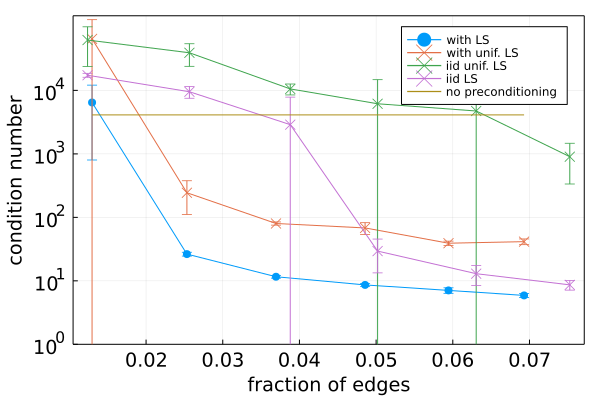

In [40]:
plot(percent_edges,cnd_number,yerror=cnd_number_std, yaxis=:log,xlabel = "fraction of edges",labels = "with LS",markerstrokecolor=:auto,markershape=:circle,markersize = 5)

plot!(percent_edges,cnd_number_no_lev, yerror = cnd_number_no_lev_std, yaxis=:log,labels = "with unif. LS",markerstrokecolor=:auto,markershape=:xcross,markersize = 5)

plot!(percent_edges_iid,cnd_number_iid_unif, yerror = cnd_number_iid_unif_std, yaxis=:log,labels = "iid unif. LS",markerstrokecolor=:auto,markershape=:xcross,markersize = 5)

plot!(percent_edges_iid,cnd_number_iid_lev, yerror = cnd_number_iid_lev_std, yaxis=:log,labels = "iid LS",markerstrokecolor=:auto,markershape=:xcross,markersize = 5)

plot!(percent_edges,cond(Lap + q * I)*ones(n_tot,1),labels = "no preconditioning",ylabel = "condition number",xtickfontsize=13,ytickfontsize=13,xguidefontsize=13,yguidefontsize=13,legendfontsize=10, framestyle = :box,margins = 0.1*2Plots.cm)
ylims!((1e0,1.5*1e5))
yticks!([1,1e1,1e2,1e3,1e4])



In [18]:
weighted = true
q = 0.1
rng = Random.default_rng()

k = 5
x1 = randn(rng, (k, 2))
x2 = randn(rng, (k, 2)) .+ 3
x = [x1; x2]

n = size(x, 1)
meta_g = MetaGraph(n)

bw = 2
for i in 1:n
    for j in (i + 1):n
        w = exp(-norm(x[i, :] - x[j, :])^2 / bw^2)
        if w > 1e-6
            e = (i, j)
            add_edge!(meta_g, i, j, :angle, 0.0)
            set_prop!(meta_g, Edge(e), :e_weight, w)
        end
    end
end

e_weights = edge_weights(meta_g)

W = diagm(e_weights)
B = magnetic_incidence(meta_g)

Lap = B * W * B'
lev = leverage_score(B, q; W)

nb_samples = 1e5
emp_lev = emp_leverage_score(rng, meta_g, q, nb_samples; weighted)

relative_error = (norm(emp_lev - lev) / norm(lev))
print("relative_error: ", relative_error, "\n")

relative_error: 0.018868474908307106


In [17]:

eigvals(Lap)

10-element Vector{Float64}:
 1.586641106603067e-16
 0.4819618317378191
 1.2053591339481688
 1.584226864764306
 2.1408298297490305
 2.468651310162506
 3.0010910166759848
 3.1995560393365734
 3.2783225491588404
 3.6194548442030845

In [40]:
log(4)

1.3862943611198906